In [2]:
# Imports

import numpy as np
import pandas as pd
import torch
from torch.nn import *
from torch import arange as torch_arange
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from random import shuffle
from torch.utils.data import DataLoader, TensorDataset
import cv2

# Read and Preprocess the Data

In [3]:
# Read the data
data_folder = os.path.join("data","landscape Images")
gray_folder = os.path.join(data_folder,"gray")
color_folder = os.path.join(data_folder,"color")
data=[]
for file in tqdm(set(os.listdir(gray_folder)).intersection(set(os.listdir(color_folder))),"Reading data images"):
    gray_image = plt.imread(os.path.join(gray_folder,file))
    color_image = cv2.cvtColor(cv2.imread(os.path.join(color_folder,file)),cv2.COLOR_BGR2RGB)
    if gray_image.shape==color_image.shape[:2] and gray_image.shape==(150,150):
        data.append([file,gray_image,color_image])
print(f"The size of the data is {len(data)}")

Reading data images: 100%|██████████| 7129/7129 [00:11<00:00, 615.98it/s]

The size of the data is 7106


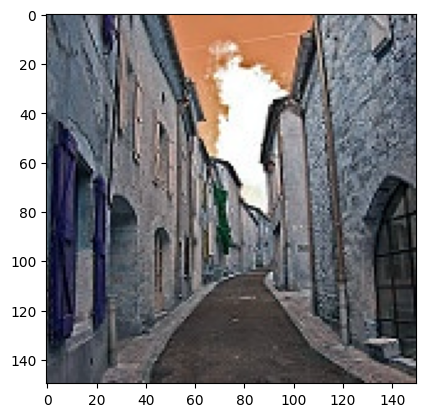

In [271]:
plt.imshow(cv2.cvtColor(data[0][2],code=cv2.COLOR_BGR2RGB))

In [196]:
test_size = 0.2
shuffle(data)
train_data= data[:int(len(data)*(1-test_size)*0.1)]
test_data = data[int(len(data)*(1-test_size)):]
print(f"Size of train data: {len(train_data)}")
print(f"Size of test data: {len(test_data)}")

Size of train data: 568
Size of test data: 1422


In [33]:
train_data[0]

['4050.jpg',
 array([[0.20392157, 0.16470588, 0.25882353, ..., 0.21960784, 0.12156863,
         0.18431373],
        [0.21568627, 0.23529412, 0.20392157, ..., 0.14901961, 0.15686275,
         0.2627451 ],
        [0.23921569, 0.25882353, 0.25490196, ..., 0.10588235, 0.18039216,
         0.22352941],
        ...,
        [0.33333333, 0.3372549 , 0.3254902 , ..., 0.07843137, 0.10196078,
         0.08235294],
        [0.42352941, 0.37647059, 0.39607843, ..., 0.10196078, 0.1254902 ,
         0.10588235],
        [0.29803922, 0.3254902 , 0.29803922, ..., 0.1372549 , 0.14901961,
         0.11764706]]),
 array([[[0.23529412, 0.2       , 0.14117647],
         [0.2       , 0.16470588, 0.10588235],
         [0.29019608, 0.25098039, 0.20392157],
         ...,
         [0.24705882, 0.21568627, 0.16470588],
         [0.15294118, 0.11764706, 0.05882353],
         [0.22352941, 0.17647059, 0.11372549]],
 
        [[0.24705882, 0.21176471, 0.15294118],
         [0.26666667, 0.23137255, 0.17254902],
   

# Design Model

In [197]:
class ImageColorizerCNNAutoEncoder(Module):
    def __init__(self):
        super(ImageColorizerCNNAutoEncoder,self).__init__()
        self.encoder = Sequential(
            Conv2d(in_channels=1,out_channels=64,kernel_size=(3,3),padding=1,stride=2),
            ReLU(),
            Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=1,stride=2),
            ReLU(),
            Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),padding=1,stride=2),
            ReLU(),
        )
        self.decoder = Sequential(
            ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(3,3),stride=2,padding=1,output_padding=1,dtype=torch.float64),
            ReLU(),
            ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(3,3),stride=2,padding=1,output_padding=1,dtype=torch.float64),
            ReLU(),
            ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(3,3),stride=2,padding=2,output_padding=1,dtype=torch.float64),
            Sigmoid()   
        )
        self.encoder.to(dtype=torch.float64)
    def forward(self,x):
        x= x.view(-1,1,150,150)
        return self.decoder(self.encoder(x))

# Train Model

In [198]:
# Hyper parameters
learning_rate = 0.001
num_epochs = 32
batch_size = 16

inputs = torch.tensor(np.array([d[1] for d in train_data]))
outputs = torch.tensor(np.array([d[2] for d in train_data]))
train_dataset = TensorDataset(inputs,outputs)
train_loader =  DataLoader(train_dataset,batch_size=batch_size)

In [200]:
cnn = ImageColorizerCNNAutoEncoder()
optimizer = torch.optim.Adam(cnn.parameters(),lr=learning_rate)
criterion = MSELoss()
for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in tqdm(train_loader,f"Epoch {epoch} training ..."):
        inputs = inputs.reshape(-1,1,150,150)
        labels = labels.reshape(-1,3,150,150)
        outputs = cnn(inputs)
        loss= criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader)}")

Epoch 0 training ...: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


Epoch [1/32], Loss: 0.07829008946582074


Epoch 1 training ...: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


Epoch [2/32], Loss: 0.07230834216130126


Epoch 2 training ...: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]


Epoch [3/32], Loss: 0.07103600518279064


Epoch 3 training ...: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


Epoch [4/32], Loss: 0.0711517033786426


Epoch 4 training ...: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


Epoch [5/32], Loss: 0.07333284806662355


Epoch 5 training ...: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]


Epoch [6/32], Loss: 0.07425399373188205


Epoch 6 training ...: 100%|██████████| 36/36 [00:41<00:00,  1.17s/it]


Epoch [7/32], Loss: 0.07180343041388311


Epoch 7 training ...: 100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


Epoch [8/32], Loss: 0.07074788468780481


Epoch 8 training ...: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


Epoch [9/32], Loss: 0.07011466002400873


Epoch 9 training ...: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


Epoch [10/32], Loss: 0.07046137383093766


Epoch 10 training ...:  75%|███████▌  | 27/36 [00:34<00:11,  1.26s/it]


KeyboardInterrupt: 

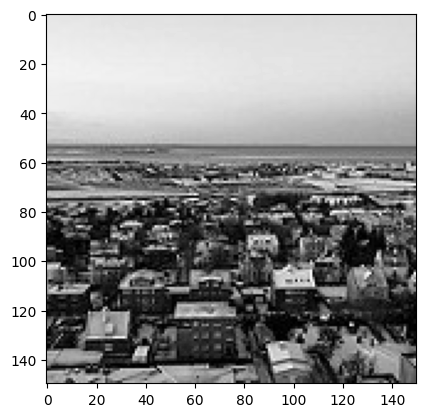

In [215]:
plt.imshow(data[1000][1]*255,cmap='gray')
plt.show()

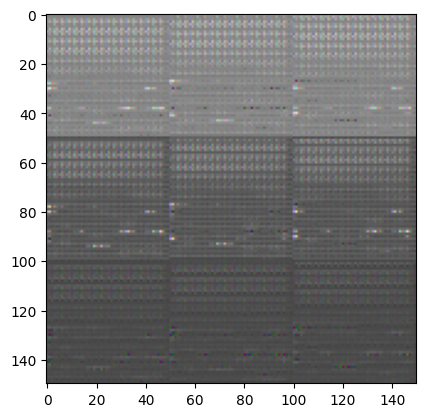

In [221]:
result =cnn(torch.tensor(data[1000][1])).squeeze(0).detach().numpy().reshape(150,150,3)
plt.imshow(result,cmap=)
plt.show()

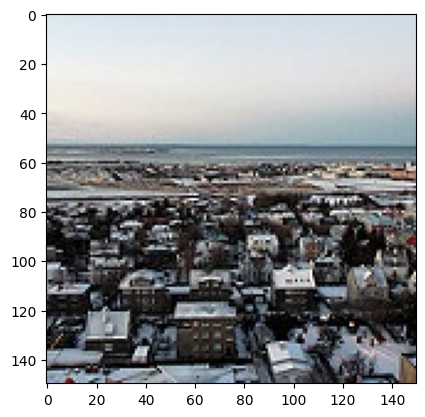

In [231]:
plt.imshow(data[1000][2])

In [232]:
data[1000][2].shape

(150, 150, 3)

In [4]:
a = plt.imread(os.path.join(color_folder,"6120.jpg"))

In [243]:
a.shape

(150, 150, 3)

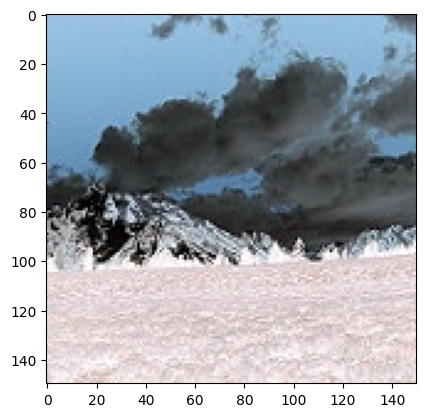

In [22]:
plt.imshow(255-cv2.cvtColor(a,code=cv2.COLOR_BGR2RGB))

dtype('uint8')